In [1]:
import pandas as pd
import sys
import sqlalchemy
import os


%matplotlib inline

CONN = sqlalchemy.create_engine('sqlite:///data.db')


#CONN.execute('PRAGMA table_info(player_stats)').fetchall()
#CONN.execute(sqlalchemy.text('SELECT player_id, full_name from player_stats where player_id = :p'),p=101106).fetchone()


In [2]:
os.listdir('../Sports')

['.DS_Store', 'Baseball', 'Basketball', 'E-Sports', 'Football', 'Soccer']

In [35]:
nba_data_path = '../Sports/Basketball/Nba Data.csv'
players_path = '../Sports/Basketball/Players.csv'
season_stats = '../Sports/Basketball/Seasons_Stats.csv'
shot_logs = '../Sports/Basketball/shot_logs.csv'

nba_df = pd.read_csv(nba_data_path)
players_df = pd.read_csv(players_path)
season_stats_df = pd.read_csv(season_stats)
shot_logs_df = pd.read_csv(shot_logs)


player_percentages = nba_df[list([column for column in nba_df.columns if ('Percentage' in column and 'Rebound' not in column and 'Effective' not in column and 'Against' not in column) or column == 'Name'])]

player_percentages.to_sql('player_percentages',CONN,if_exists='replace')
players_df.to_sql('player',CONN, if_exists='replace')


players_df.columns = ['id','name','height','weight','college','born','birth_city','birth_state']

columns = list(season_stats_df.columns)
columns[0] = 'id'
season_stats_df.columns = columns


duplicate_players_total = nba_df[(nba_df.duplicated(subset=['Full Name'])) & (nba_df['Team'] == 'TOTAL')]

nba_df = nba_df.drop_duplicates(subset=['Full Name'], keep=False)

nba_player_stats_df = pd.concat([nba_df, duplicate_players_total])

nba_player_stats_cols = list(nba_player_stats_df.columns)
nba_player_stats_cols[32] = 'Second Pass Hockey Assist'
nba_player_stats_cols = ['_'.join(column.strip().lower().split())  for column in nba_player_stats_cols]

nba_player_stats_df.columns = nba_player_stats_cols


nba_player_stats_df.team = nba_player_stats_df.team.apply(lambda x : x.lower())


nbapstatsdfkmeans = nba_player_stats_df[['player_id',
 'pull_up_3_point_field_goals_attempted_per_game',
 'catch_and_shoot_3_point_attempts_per_game']]


nba_player_stats_df[nba_player_stats_df.full_name == 'Stephen Curry']



,player_id,full_name,first_name,last_name,team,games_played,minutes,pull_up_shots_points_per_game,pull_up_field_goals_made_per_game,pull_up_field_goals_attempted_per_game,...,field_goal_percentage_close_range,points_per_game_catch_and_shoot,field_goal_percentage_catch_and_shoot,points_per_game_pull_up,field_goal_percentage_pull_up,field_goal_attempted_drive,field_goal_attempted_close_range,field_goal_attempted_catch_and_shoot,field_goal_attempted_pull_up,effective_field_goal_percentage
184,201939,Stephen Curry,Stephen,Curry,gsw,77,36.701732,11.012987,4.493506,10.311688,...,0.5,4.142857,0.489177,11.012987,0.435768,2.87013,0.181818,3.0,10.311688,0.56365


In [4]:
# Solving null values problem in df. 
nbapstatsdfkmeans =  nbapstatsdfkmeans.fillna(value=0.0)
nbapstatsdfkmeans.head()


,player_id,pull_up_3_point_field_goals_attempted_per_game,catch_and_shoot_3_point_attempts_per_game
0,101106,0.000000,0.000000
1,101107,0.242424,3.257576
2,101108,2.129032,1.096774
3,101109,1.015385,1.969231
4,101110,0.441558,4.259740


Cluster: 0
47         Al Harrington
48         Nazr Mohammed
49         Rashard Lewis
50           Elton Brand
54          Shawn Marion
55           Jason Terry
56     Metta World Peace
57      Andrei Kirilenko
58         Manu Ginobili
59       Andrea Bargnani
60     LaMarcus Aldridge
61            Randy Foye
65             JJ Redick
66      Hilton Armstrong
67       Thabo Sefolosha
71       Shawne Williams
72           Rajon Rondo
73            Kyle Lowry
77         Jordan Farmar
78         Joel Freeland
79           Steve Novak
80         Solomon Jones
81             PJ Tucker
82          Paul Millsap
83          Ryan Hollins
87       Jose Juan Barea
88           Mike Harris
89             Greg Oden
90          Kevin Durant
91            Al Horford
             ...        
142       Jerryd Bayless
155         Courtney Lee
168     Luc Mbah a Moute
174       Othyus Jeffers
177       Cartier Martin
192           Earl Clark
195          Austin Daye
201          Eric Maynor
207        Byr

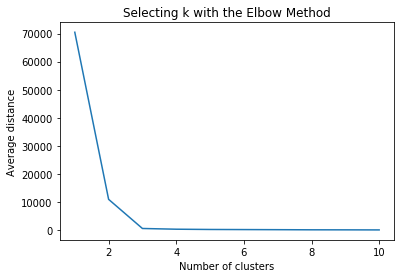

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import collections
import numpy as np
import matplotlib.pylab as plt


name_lookup = {record['player_id']:record['full_name'] for record in nba_player_stats_df[['player_id','full_name']].to_dict('records')}
clusters=range(1,11)
meandist = []

for k in clusters:
    train_set = nbapstatsdfkmeans
    model = KMeans(n_clusters=k)
    model.fit(train_set)
    model.predict(train_set)
    meandist.append(sum(np.min(cdist(train_set, model.cluster_centers_, 'euclidean'), axis=1)) / train_set.shape[0])

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')



# With 3 clusters, let's see which players are in the cluster
model = KMeans(n_clusters=3)
model.fit(train_set)

clustering = collections.defaultdict(list)


for idx, label in enumerate(model.labels_):
    clustering[label].append(idx)



for cluster in clustering:
    print("Cluster: %d"%(cluster))
    player_cluster = nbapstatsdfkmeans[nbapstatsdfkmeans.index.isin(clustering[cluster])][['player_id']]
    player_cluster.name = player_cluster.player_id.apply(lambda x : name_lookup[x])
    print(player_cluster.name)
    


In [6]:



r_url = "http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=%s&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0"



In [9]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'
}


get_data = []


with open('shot_data.txt','w') as shot_log_writer:
    for i, player_id in enumerate(nba_player_stats_df.player_id):
        print(i, player_id)
        url = r_url%(player_id)
        print(url)
        r = requests.get(url,headers=headers)
        get_data.append(r.json())

        
        
    
    

(0, 101106)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=101106&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(1, 101107)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=101107&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(2, 101108)
ht

(17, 101141)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=101141&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(18, 101142)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=101142&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(19, 101145)

(34, 1712)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=1712&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(35, 1713)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=1713&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(36, 1717)
http://st

(51, 200756)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=200756&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(52, 200757)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=200757&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(53, 200761)

(68, 201144)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201144&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(69, 201145)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201145&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(70, 201147)

(85, 201203)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201203&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(86, 201228)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201228&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(87, 201229)

(102, 201581)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201581&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(103, 201582)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201582&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(104, 2015

(119, 201933)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201933&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(120, 201934)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201934&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(121, 2019

(136, 201959)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201959&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(137, 201960)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201960&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(138, 2019

(153, 202087)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202087&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(154, 202091)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202091&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(155, 2021

(170, 202337)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202337&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(171, 202338)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202338&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(172, 2023

(187, 202391)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202391&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(188, 202397)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202397&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(189, 2024

(204, 202697)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202697&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(205, 202698)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202698&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(206, 2026

(221, 202738)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202738&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(222, 202779)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202779&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(223, 2028

(238, 203086)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203086&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(239, 203087)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203087&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(240, 2030

(255, 203108)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203108&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(256, 203109)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203109&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(257, 2031

(272, 203141)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203141&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(273, 203142)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203142&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(274, 2031

(289, 203461)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203461&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(290, 203462)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203462&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(291, 2034

(306, 203488)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203488&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(307, 203489)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203489&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(308, 2034

(323, 203507)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203507&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(324, 203508)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203508&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(325, 2035

(340, 203584)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203584&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(341, 2037)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2037&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(342, 203810)


(357, 2248)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2248&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(358, 2365)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2365&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(359, 2399)
http:/

(374, 2548)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2548&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(375, 2549)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2549&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(376, 2550)
http:/

(391, 2694)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2694&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(392, 2730)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2730&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(393, 2732)
http:/

(408, 2760)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2760&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(409, 2767)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2767&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(410, 2772)
http:/

(425, 201150)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201150&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(426, 201166)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201166&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(427, 2011

(442, 201977)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201977&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(443, 201986)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=201986&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(444, 2023

(459, 202952)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=202952&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(460, 203099)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=203099&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(461, 2031

(476, 2557)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2557&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(477, 2581)
http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS=2014-15&ContextFilter=&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerID=2581&PlayerPosition=&PlusMinus=N&Position=&Rank=N&RookieYear=&Season=2014-15&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0
(478, 2736)
http:/

In [12]:
import json
with open('shot_data.txt','w') as shot_log_writer:
    json.dump(get_data,shot_log_writer)

In [40]:
import json


with open('shot_data.txt') as shot_log_reader:
    get_data = json.load(shot_log_reader)
    
    

def get_player_shots(player):
    records = []
    league_averages = []
    for result in player['resultSets']:
        name = result['name']
        headers = result['headers']
        if name == 'Shot_Chart_Detail':
            for row in result['rowSet']:
                records.append(dict(zip(headers,row)))
                
    return records

pds = []
for  player in get_data:
    pds.append(pd.DataFrame(get_player_shots(player)))

    
massive_df = pd.concat(pds)

massive_df.to_sql('shot_charts',CONN,if_exists='replace')

massive_df

    
    

,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,MINUTES_REMAINING,...,SHOT_ATTEMPTED_FLAG,SHOT_DISTANCE,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM
0,Alley Oop Dunk Shot,Made Shot,20141029,44,0021400014,Shot Chart Detail,SAC,0,1,8,...,1,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612744,Golden State Warriors,GSW
1,Layup Shot,Made Shot,20141029,336,0021400014,Shot Chart Detail,SAC,-5,14,11,...,1,1,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612744,Golden State Warriors,GSW
2,Driving Slam Dunk Shot,Made Shot,20141101,2,0021400038,Shot Chart Detail,GSW,0,1,11,...,1,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612744,Golden State Warriors,LAL
3,Turnaround Hook Shot,Missed Shot,20141101,25,0021400038,Shot Chart Detail,GSW,-51,55,8,...,1,7,0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612744,Golden State Warriors,LAL
4,Putback Layup Shot,Made Shot,20141101,53,0021400038,Shot Chart Detail,GSW,-5,4,5,...,1,0,1,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612744,Golden State Warriors,LAL
5,Jump Shot,Missed Shot,20141101,136,0021400038,Shot Chart Detail,GSW,-100,25,9,...,1,10,0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612744,Golden State Warriors,LAL
6,Layup Shot,Missed Shot,20141101,181,0021400038,Shot Chart Detail,GSW,0,25,6,...,1,2,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612744,Golden State Warriors,LAL
7,Tip Shot,Missed Shot,20141101,182,0021400038,Shot Chart Detail,GSW,1,1,6,...,1,0,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612744,Golden State Warriors,LAL
8,Putback Layup Shot,Missed Shot,20141101,185,0021400038,Shot Chart Detail,GSW,0,9,6,...,1,0,0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612744,Golden State Warriors,LAL
9,Floating Jump shot,Made Shot,20141101,327,0021400038,Shot Chart Detail,GSW,0,89,6,...,1,8,1,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,1610612744,Golden State Warriors,LAL


In [61]:
player_zone_groups = massive_df.groupby(['PLAYER_ID','SHOT_ZONE_BASIC','EVENT_TYPE'])['EVENT_TYPE'].count().to_dict()

records = []
for record in player_zone_groups:
    player_id, zone, event = record
    result = player_zone_groups[record]
    records.append({"player_id":player_id, "zone":zone,"event":event,"count":result})

cache_player_results = pd.DataFrame(records)
cache_player_results.to_sql('player_stats_by_zone',CONN,if_exists='replace')
    


In [95]:
lol = {
"name": "LeagueAverages",
"headers": [
"GRID_TYPE",
"SHOT_ZONE_BASIC",
"SHOT_ZONE_AREA",
"SHOT_ZONE_RANGE",
"FGA",
"FGM",
"FG_PCT"
],
"rowSet": [
[
"League Averages",
"Above the Break 3",
"Back Court(BC)",
"Back Court Shot",
55,
2,
0.036
],
[
"League Averages",
"Above the Break 3",
"Center(C)",
"24+ ft.",
9724,
3289,
0.338
],
[
"League Averages",
"Above the Break 3",
"Left Side Center(LC)",
"24+ ft.",
15408,
5259,
0.341
],
[
"League Averages",
"Above the Break 3",
"Right Side Center(RC)",
"24+ ft.",
15148,
5194,
0.343
],
[
"League Averages",
"Backcourt",
"Back Court(BC)",
"Back Court Shot",
427,
11,
0.026
],
[
"League Averages",
"In The Paint (Non-RA)",
"Center(C)",
"8-16 ft.",
6599,
2771,
0.42
],
[
"League Averages",
"In The Paint (Non-RA)",
"Center(C)",
"Less Than 8 ft.",
20196,
7693,
0.381
],
[
"League Averages",
"In The Paint (Non-RA)",
"Left Side(L)",
"8-16 ft.",
1706,
711,
0.417
],
[
"League Averages",
"In The Paint (Non-RA)",
"Right Side(R)",
"8-16 ft.",
2016,
801,
0.397
],
[
"League Averages",
"Left Corner 3",
"Left Side(L)",
"24+ ft.",
7374,
2801,
0.38
],
[
"League Averages",
"Mid-Range",
"Center(C)",
"16-24 ft.",
7850,
3130,
0.399
],
[
"League Averages",
"Mid-Range",
"Center(C)",
"8-16 ft.",
1963,
847,
0.431
],
[
"League Averages",
"Mid-Range",
"Left Side Center(LC)",
"16-24 ft.",
8034,
3153,
0.392
],
[
"League Averages",
"Mid-Range",
"Left Side(L)",
"16-24 ft.",
5818,
2282,
0.392
],
[
"League Averages",
"Mid-Range",
"Left Side(L)",
"8-16 ft.",
8257,
3239,
0.392
],
[
"League Averages",
"Mid-Range",
"Right Side Center(RC)",
"16-24 ft.",
8914,
3454,
0.387
],
[
"League Averages",
"Mid-Range",
"Right Side(R)",
"16-24 ft.",
5345,
2162,
0.404
],
[
"League Averages",
"Mid-Range",
"Right Side(R)",
"8-16 ft.",
7595,
3007,
0.396
],
[
"League Averages",
"Restricted Area",
"Center(C)",
"Less Than 8 ft.",
66134,
39735,
0.601
],
[
"League Averages",
"Right Corner 3",
"Right Side(R)",
"24+ ft.",
6987,
2738,
0.392
]
]
}



headers = lol['headers'][1:]

records = []
for row in lol['rowSet']:
    record = dict(zip(headers,row))
    records.append(record)
    

league_averages = {
                   "Above the Break 3":0.340,
                   "Backcourt":0.026,
                   "In The Paint (Non-RA)":0.40375,
                   "Left Corner 3":0.38,
                   "Right Corner 3": 0.392,
                   "Mid-Range":sum([0.399, 0.431, 0.392, 0.392, 0.392,0.387, 0.404,0.396]) / 8,
                   "Restricted Area": 0.601
                  }

league_averages




    

{'Above the Break 3': 0.34,
 'Backcourt': 0.026,
 'In The Paint (Non-RA)': 0.40375,
 'Left Corner 3': 0.38,
 'Mid-Range': 0.39912499999999995,
 'Restricted Area': 0.601,
 'Right Corner 3': 0.392}

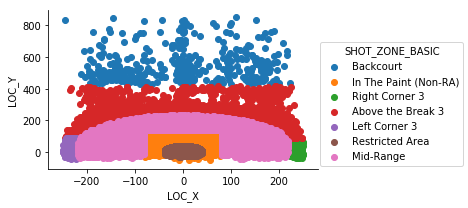

In [93]:
import seaborn as sns
from matplotlib import pyplot

kd_stats = massive_df[['LOC_X','LOC_Y','SHOT_DISTANCE','EVENT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_TYPE','SHOT_ZONE_BASIC']]


event_types = list(set(kd_stats['SHOT_ZONE_BASIC']))


fg = sns.FacetGrid(data=kd_stats, hue='SHOT_ZONE_BASIC', hue_order=event_types, aspect=1.61)

fg.map(pyplot.scatter, 'LOC_X','LOC_Y').add_legend()










In [15]:
from sklearn import tree
import graphviz

clf = tree.DecisionTreeClassifier()

massive_df[['LOC_X','LOC_Y','SHOT_ZONE_BASIC']]

clf = clf.fit(zip(massive_df['LOC_X'],massive_df['LOC_Y']), massive_df['SHOT_ZONE_BASIC'])


clf.predict([[220., 300]])


array([u'Above the Break 3'], dtype=object)

In [14]:
clf.predict([[-220., 10.]])

array([u'Left Corner 3'], dtype=object)

In [133]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'
}


player_pages = []

for player_id in nba_player_stats_df.player_id:
    r = requests.get('http://stats.nba.com/player/%s/traditional/'%(player_id),headers=headers)
    player_pages.append(r.text)



    
    


In [139]:
json.dump(player_pages,open('player_pages.txt','w'))

In [145]:
!pip install graphviz

In [114]:
import requests

r = requests.post('http://0.0.0.0:8886/player/101106/zone',data={'x':10,'y':240})

r.json()

ValueError: No JSON object could be decoded

In [125]:
r = requests.post('http://0.0.0.0:8886/player/201939/zone',data={'x':24,'y':0})
r.json()


{u'euclidean_distance': 240.0,
 u'percent_difference_average': 0.1307272727272727,
 u'percentage_success': 0.5227272727272727,
 u'player_id': 201939,
 u'zone': u'Right Corner 3'}